# EDA - Exploratory Data Analysis
<br><br><br>

In [114]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import geopandas as gpd
import contextily as ctx
from geopy.geocoders import Nominatim
import warnings
warnings.filterwarnings("ignore")



# from scipy.stats import chi2_contingency

hechos = pd.read_csv("datasets/hechos.csv")
victimas = pd.read_csv("datasets/victimas.csv")
df_victimas = pd.read_csv("datasets/df_victimas.csv")

<br><br><br>
### DESCRIPCION BASICA DE LOS DATOS
*Los nulos y duplicados se trabajaron en el ETL*

In [22]:
df_victimas.iloc[:,[1,2,3,4,5,6,8,9,10,11,12,13,14,15]].describe()

,ID_HECHO,ROL,SEXO,EDAD,RANGO_ETAREO,FECHA,TIPO_DE_CALLE,CALLE,CRUCE,COMUNA,LONGITUD,LATITUD,VICTIMA,ACUSADO
count,717,717,717,717,717,717,717,717,540,717,717,717,717,717
unique,696,5,3,86,6,598,4,280,317,16,605,605,9,10
top,2017-0035,CONDUCTOR,MASCULINO,SD,18_33,2017-02-26,AVENIDA,"PAZ, GRAL. AV.","PAZ, GRAL. AV.",1,.,.,MOTO,AUTO
freq,3,330,545,53,264,3,442,61,14,93,13,13,302,208


De esta descripción podemos destacar:
* Entre el año 2016 y 2021 hubo **717 víctimas fatales** de **696 siniestros viales** en toda la Ciudad Autónoma de Buenos Aires
* Los perfiles más comunes de las víctimas corresponde al siguiente:
    * Rol: **CONDUCTOR** (330 víctimas eran conductores)
    * Sexo: **MASCULINO** (545 víctimas fueron hombres)
    * Rango etáreo: entre **18 y 33** años (264 víctimas corresponden a este rango de edad)
    * Vehículo: **MOTO** (302 víctimas se trasladaban en moto)
* Vehículo del acusado que más siniestros fatales provocó: **AUTO** (provocó la muerte de 208 víctimas)
* Tipo de vía con mayor ocurrencia de siniestros viales: **AVENIDAS** (de los 696 siniestros, 492 ocurrieron en avenidas)
* Total de vías en las que se registraron los 696 siniestros: **280 vías** distintas, de las cuales a su vez ocurrieron en **540 cruces**
* Vía que más víctimas fatales registró: **AVENIDA GENERAL PAZ** (un total de 75 víctimas, de las cuales 14 fueron en cruces de esta avenida)
* La **COMUNA 1** presenta mayor cantidad de víctimas: 93 víctimas

<br><br><br>
### EVALUACION DE VICTIMAS FATALES POR AÑO

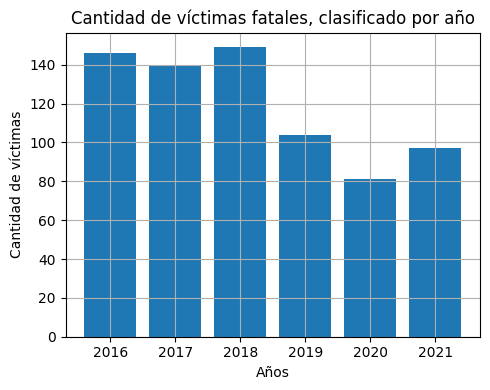

In [41]:
conteo_registros = df_victimas['FECHA'].dt.year.value_counts()

fig, ax1 = plt.subplots(figsize=(5,4))
ax1.bar(conteo_registros.index, conteo_registros.values)
ax1.set_xlabel('Años')
ax1.set_ylabel('Cantidad de víctimas')
ax1.set_title('Cantidad de víctimas fatales, clasificado por año')
ax1.grid(True)

plt.tight_layout()

De este gráfico se puede observar claramente una reducción de la siniestralidad a partir del año 2019, considerando que el año 2020 tiene una reducción aun más pronunciada, la cual tiene correlación con un evento atípico (la pandemia del COVID-19, que llevó a una caída considerable de la actividad), volviendo a los valores normales en el año 2021.<br>
Este dato es relevante considerar, por el sesgo que puede generar sobre algunas estimaciones este evento atípico registrado durante el año 2020 (por ejemplo, al calcular la cantidad de víctimas promedio anualizadas se ve afectado si consideramos el año 2020).

<br><br><br>
### ANALISIS DE VÍCTIMAS FATALES POR MES (ENTRE 2016 Y 2021)

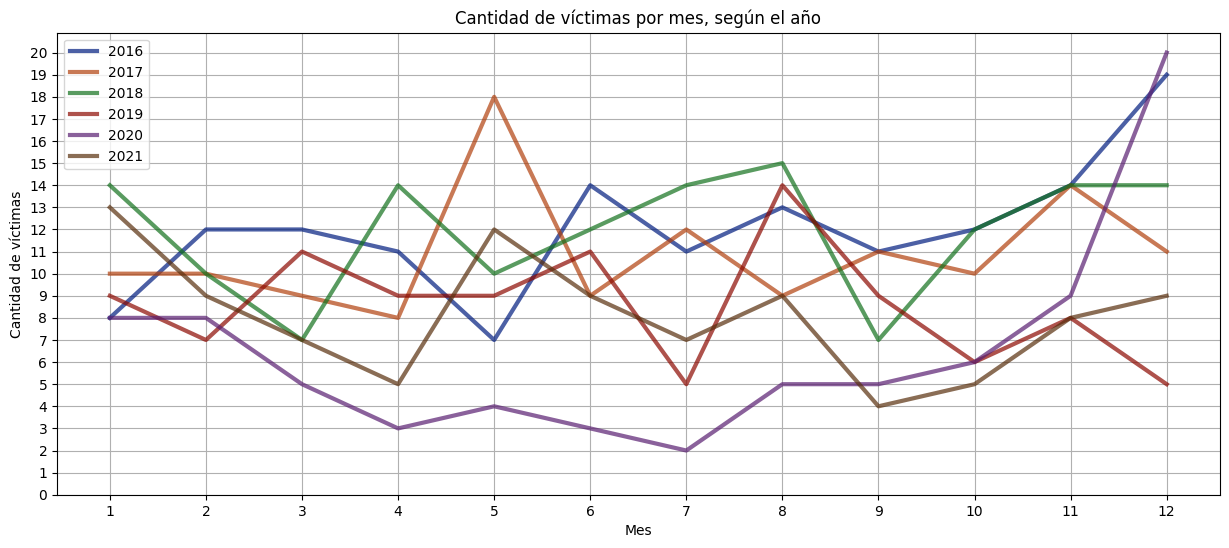

In [ ]:

# Contar la cantidad de filas por año y mes
counts = hechos.groupby(['ANIO', 'MES']).size().unstack(fill_value=0)

# Crear el gráfico de líneas con un grosor uniforme y paleta de colores modificada
plt.figure(figsize=(15, 6))
for year in counts.index:
    plt.plot(counts.columns, counts.loc[year], label=str(year), linewidth=3, alpha=0.7)  # Grosor uniforme y transparencia
sns.set_palette("Set3")  # Cambiar la paleta de colores
plt.xlabel('Mes')
plt.ylabel('Cantidad de víctimas')
plt.title('Cantidad de víctimas por mes, según el año')
plt.legend()
plt.grid(True)
plt.xticks(range(1, 13))
plt.yticks(range(0, max(counts.values.max(), 1) + 1))  # Set y-ticks as integers
plt.show()

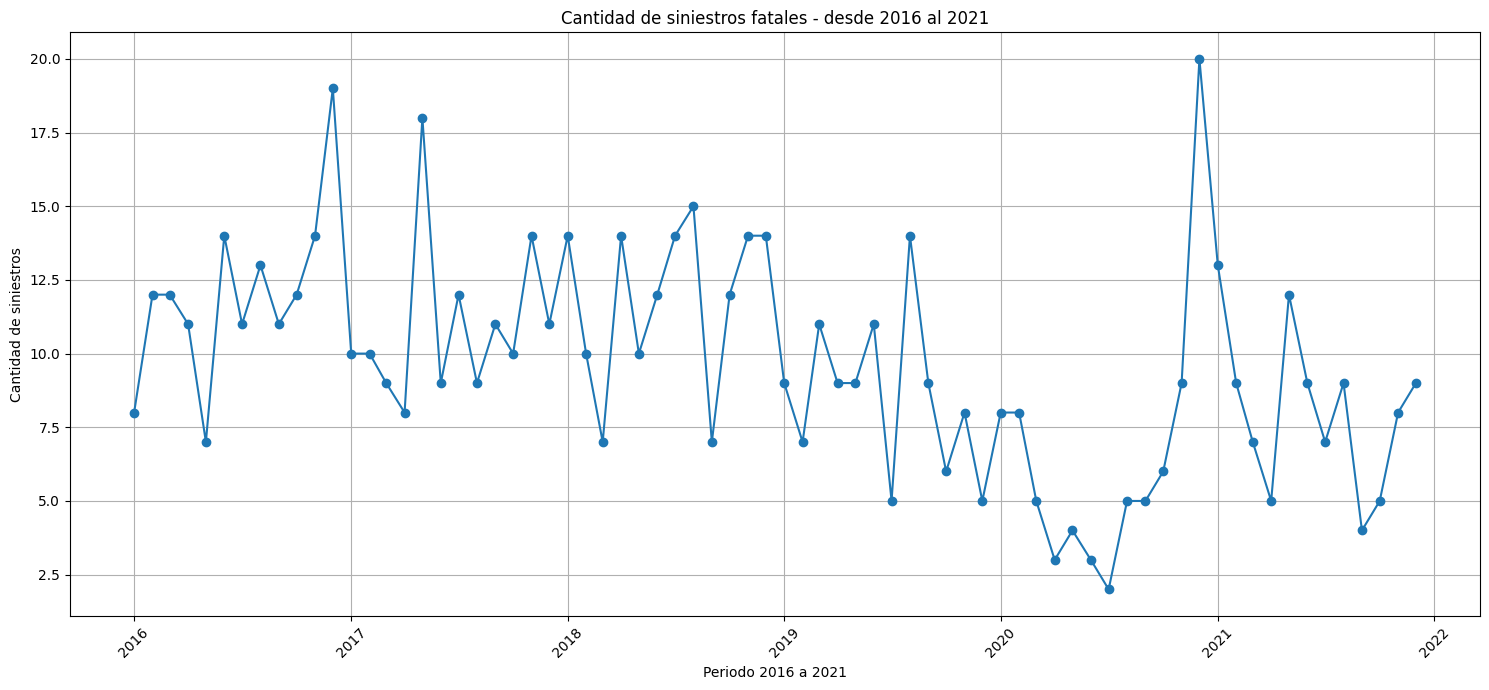

In [42]:
# Agrupar los hechos por año y mes, contar la cantidad de registros para cada combinación
conteo_registros = hechos.groupby(['ANIO', 'MES']).size().reset_index(name='CANTIDAD_REGISTROS')

# Crear una nueva columna 'FECHA' combinando año y mes para poder ordenar correctamente
conteo_registros['FECHA'] = pd.to_datetime(conteo_registros['ANIO'].astype(str) + '-' + conteo_registros['MES'].astype(str))

# Ordenar los hechos por fecha
conteo_registros = conteo_registros.sort_values('FECHA')

plt.figure(figsize=(15,7))
# Graficar la curva
plt.plot(conteo_registros['FECHA'], conteo_registros['CANTIDAD_REGISTROS'], marker='o')

# Añadir etiquetas y título
plt.xlabel('Periodo 2016 a 2021')
plt.ylabel('Cantidad de siniestros')
plt.title('Cantidad de siniestros fatales - desde 2016 al 2021')
plt.grid(True)
# Rotar los ejes X para mejorar la legibilidad de los meses
plt.xticks(rotation=45)
plt.tight_layout()

En este gráfico se observan picos bastante cíclicos mes a mes, que pareciera no responder a ningún patrón, pero es posible observar una tendencia a caer la cantidad de siniestros desde el año 2017 (interrumpido en el 2020 por la pandemia).<br>
Para diciembre del año 2020 se observa el pico más elevado (20 víctimas, más del doble de cualquier otro mes del mismo año), lo cual puede tener correlación con la salida de la pandemia (y la llegada del verano), volviendo desde entonces a los valores normales.

<br><br><br>
### ANALISIS DE SINIESTRALIDAD POR VIAS (TIPO DE VIAS, NOMBRES, ETC)

In [45]:
hechos["TIPO_DE_CALLE"].value_counts()

TIPO_DE_CALLE
AVENIDA      429
CALLE        136
AUTOPISTA     66
GRAL PAZ      65
Name: count, dtype: int64

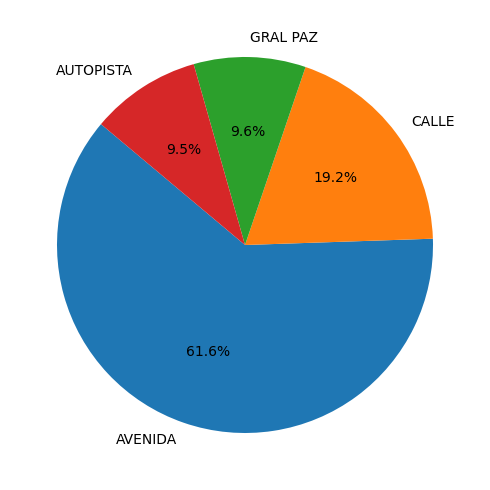

In [43]:
conteo_registros = df_victimas['TIPO_DE_CALLE'].value_counts()


plt.figure(figsize=(6,5))
plt.pie(conteo_registros, labels=conteo_registros.index, autopct='%1.1f%%', startangle=140)


plt.tight_layout()

Text(0.5, 0, 'Cruce')

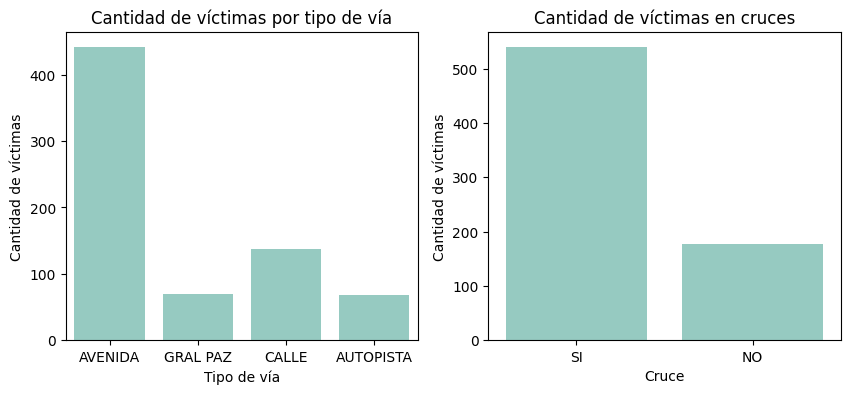

In [259]:
# Se crea el gráfico
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(data=df_victimas, x='TIPO_DE_CALLE', ax=axes[0])
axes[0].set_title('Cantidad de víctimas por tipo de vía') ; axes[0].set_ylabel('Cantidad de víctimas') ; axes[0].set_xlabel('Tipo de vía')

sns.countplot(data=df_victimas, x='EN_CRUCE', ax=axes[1])
axes[1].set_title('Cantidad de víctimas en cruces') ; axes[1].set_ylabel('Cantidad de víctimas') ; axes[1].set_xlabel('Cruce')
    
# Mostramos los gráficos

Se puede observar que la mayor parte de los siniestros ocurren en **AVENIDAS**, y en gran medida en los **CRUCES**. Sin embargo, comprendiendo que la Ciudad de Buenos Aires presenta una cantidad muy elevada de avenidas y calles, es posible estimar que la cantidad de siniestros viales por km de ruta, será mucho más elevada en la General Paz que rodea parte de la ciudad, y luego en las 10 autopistas que recorren la ciudad; por lo que vemos una concentración especial en estas rutas específicamente.

In [47]:
df_victimas["CALLE"].value_counts()[df_victimas["CALLE"].value_counts() > 10]

CALLE
PAZ, GRAL. AV.                                61
RIVADAVIA AV.                                 20
DEL LIBERTADOR AV.                            19
AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI    14
AUTOPISTA PERITO MORENO                       13
ALBERDI, JUAN BAUTISTA AV.                    13
AUTOPISTA 25 DE MAYO                          12
SAN MARTIN AV.                                11
CORRIENTES AV.                                11
Name: count, dtype: int64

In [48]:
df_victimas["CRUCE"].value_counts()[df_victimas["CRUCE"].value_counts() > 5]

CRUCE
PAZ, GRAL. AV.              14
ESCALADA AV.                 9
RIVADAVIA AV.                8
INDEPENDENCIA AV.            7
BALBIN, RICARDO, DR. AV.     6
DEL LIBERTADOR AV.           6
RIVERA INDARTE AV.           6
PUEYRREDON AV.               6
Name: count, dtype: int64

In [49]:
hechos["LUGAR_DEL_HECHO"].value_counts()[hechos["LUGAR_DEL_HECHO"].value_counts() > 2]

LUGAR_DEL_HECHO
27 DE FEBRERO AV. y ESCALADA AV.                         5
PAZ, GRAL. AV. y BALBIN, RICARDO, DR. AV.                4
PAZ, GRAL. AV. y DEL LIBERTADOR AV.                      4
CASTILLO, RAMON S., PRES. AV. y CALLE 12 (NO OFICIAL)    3
DEL LIBERTADOR AV. y RAMOS MEJIA, JOSE MARIA, DR. AV.    3
ALCORTA, AMANCIO AV. y BONAVENA, OSCAR NATALIO           3
INDEPENDENCIA AV. y CEVALLOS, VIRREY                     3
PAZ, GRAL. AV. y DE LOS CORRALES AV.                     3
Name: count, dtype: int64

Del gráfico y las cifras obtenidas, podemos observar una predominancia de los accidentes en las avenidas, mayor al 60%, llegando al 70% si tomamos a la Av. Gral. Paz como una más. Sin embargo, al analizar la cantidad de accidentes por calle específica, existen unas pocas en las que ocurren muchos de estos siniestros, destacando en primer lugar la Avenida General Paz (a la cual se le otorgó una categoría propia por la enorme cantidad de accidentes que se producen allí, considerando además los cruces), siendo 3 veces superior a la calle que le sigue en cantidad de accidentes fatales, la Av. Rivadavia y luego al mismo nivel la Av. Libertador. Si tomamos el lugar del hecho, nos encontramos con un cruce que ya tiene 5 accidentes fatales: Av. 27 de febrero y Av. Escalada, y dos que suman 4 siniestros, ambos en la Av. Gral. Paz, en el cruce Av. Balbin, y otro en el cruce de Av. Libertador.

Aquí ya se cuenta con información relevante para tomar decisiones en materia preventiva, por parte de la secretaría de tránsito de la ciudad de Buenos Aires. Luego se puede precisar las alturas y los cruces, junto con los horarios para implementar medidas como incrementar los controles, y la colocación de cámaras de seguridad y radares de velocidad.

<br><br><br>
### ANALISIS DE SINIESTRALIDAD POR COMUNAS

PRINCIPALES BARRIOS DE LAS COMUNAS:
1. Retiro, San Nicolás, Puerto Madero, San Telmo, Montserrat y Constitución
2. Recoleta
3. Balvanera y San Cristóbal
4. Almagro y Boedo
5. Caballito
6. Flores
7. Villa Crespo y Chacarita
8. Palermo
9. La Paternal, Villa Ortúzar y Villa Santa Rita
10. Villa Soldati, Villa Riachuelo y Flores Sur
11. Villa Devoto, Villa del Parque, Villa Urquiza y Coghlan
12. Saavedra, Villa Pueyrredón, Núñez y Colegiales
13. Belgrano
14. Palermo
15. Mataderos y Vélez Sarsfield

In [67]:
hechos["COMUNA"].value_counts()[hechos["COMUNA"].value_counts() > 50]

COMUNA
1    90
4    76
9    73
8    65
7    60
Name: count, dtype: int64

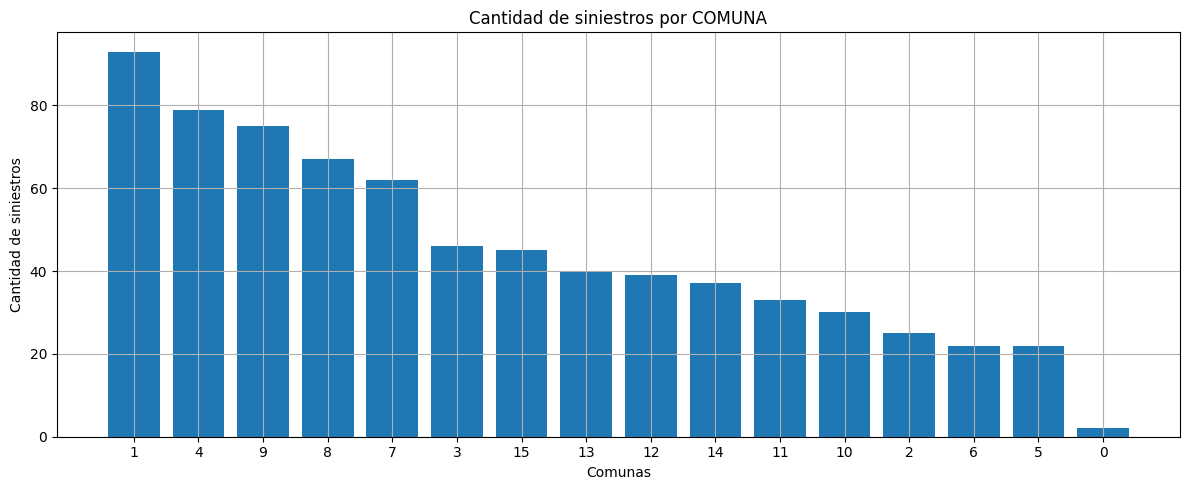

In [66]:
# Contar el número de registros por COMUNA
conteo_registros = df_victimas['COMUNA'].value_counts()

# Crear la figura y los ejes para el gráfico de barras
fig, ax1 = plt.subplots(figsize=(12, 5))

# Gráfico de barras
ax1.bar(conteo_registros.index, conteo_registros.values)
ax1.set_xlabel('Comunas')
ax1.set_ylabel('Cantidad de siniestros')
ax1.set_title('Cantidad de siniestros por COMUNA')
ax1.grid(True)

plt.tight_layout()
plt.show()

Resaltan fuertemente las comunas 1 (con el 13% de todos los siniestros por sobre las 15 comunas), 4, 7, 8 y 9, por sobre las demás. Debería ser este un foco importante también para investigar más al momento de desarrollar e implementar medidas preventivas.

In [77]:
df_mapa = gpd.read_file("mapa\comunas_wgs84.shp")

In [78]:
loc_hechos = hechos[hechos["LONGITUD"]!="."]

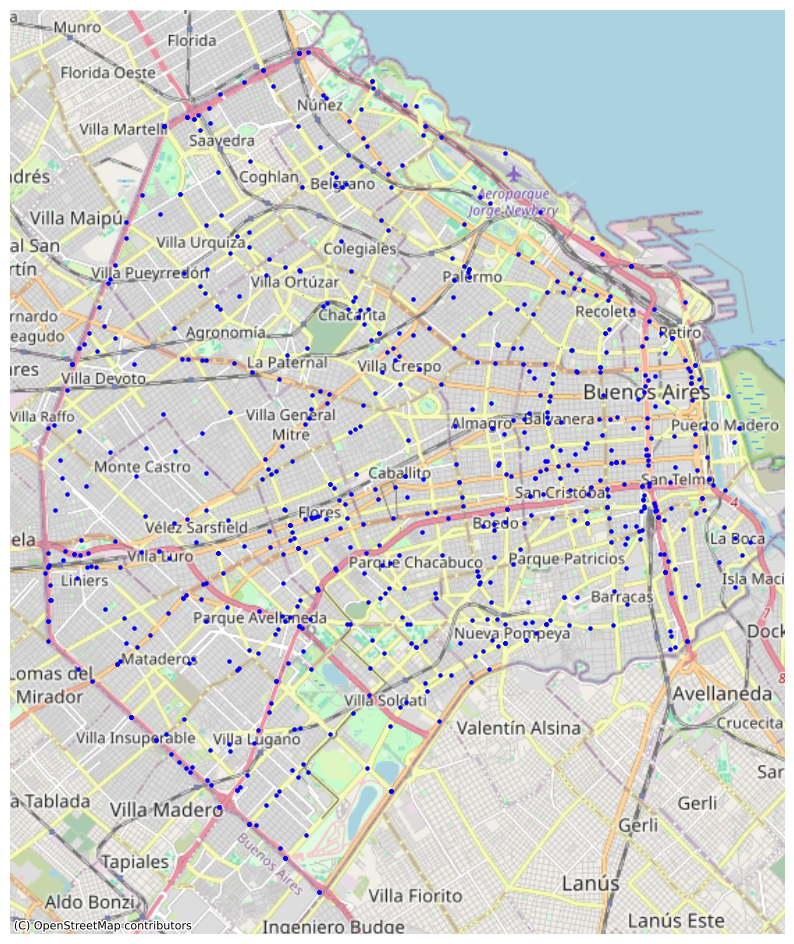

In [87]:
gdf_homicidios = gpd.GeoDataFrame(loc_hechos, geometry=gpd.points_from_xy(loc_hechos['LONGITUD'], loc_hechos['LATITUD']))
gdf_homicidios.crs = 'epsg:4326' 

gdf_homicidios = gdf_homicidios[(gdf_homicidios['LONGITUD'] != 0) & (gdf_homicidios['LATITUD'] != 0) & (gdf_homicidios['LONGITUD'] != '.') & (gdf_homicidios['LATITUD'] != '.')]

gdf_homicidios = gdf_homicidios.to_crs(epsg=3857)

ax = gdf_homicidios.plot(marker='o', color='blue', markersize=5, figsize=(12, 12)) 
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik) 
ax.set_axis_off()
plt.show()

<br><br><br>
### ANALISIS DE VICTIMAS Y ACUSADOS

In [68]:
hechos["VICTIMA"].value_counts()

VICTIMA
MOTO           295
PEATON         264
AUTO            84
BICICLETA       29
SD               9
CARGAS           7
PASAJEROS        5
MOVIL            2
PEATON_MOTO      1
Name: count, dtype: int64

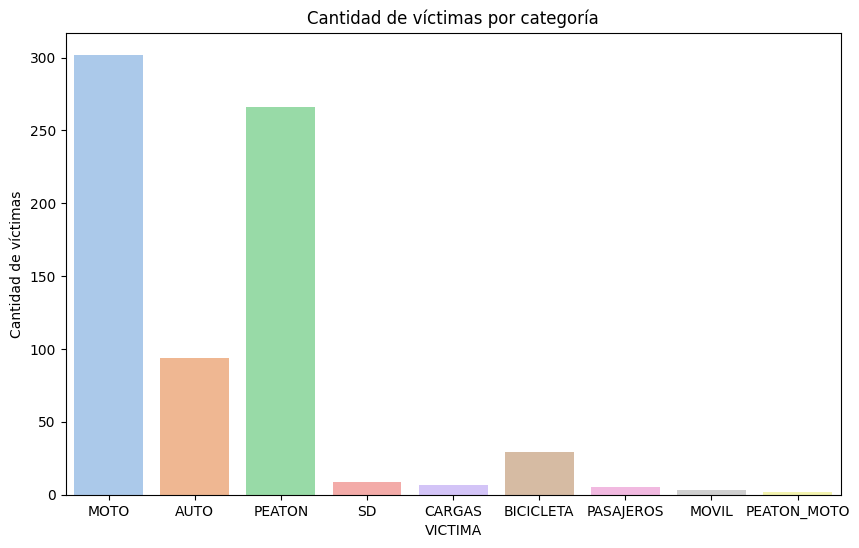

In [257]:
# gráfico de víctimas dividido por categorías
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data=df_victimas, x='VICTIMA', palette='pastel')
ax.set_title('Cantidad de víctimas por categoría')
ax.set_ylabel('Cantidad de víctimas')
plt.show()

In [72]:
hechos["ACUSADO"].value_counts()

ACUSADO
AUTO           203
PASAJEROS      173
CARGAS         146
OBJETO FIJO     63
MOTO            57
SD              23
MULTIPLE        17
BICICLETA        7
OTRO             6
TREN             1
Name: count, dtype: int64

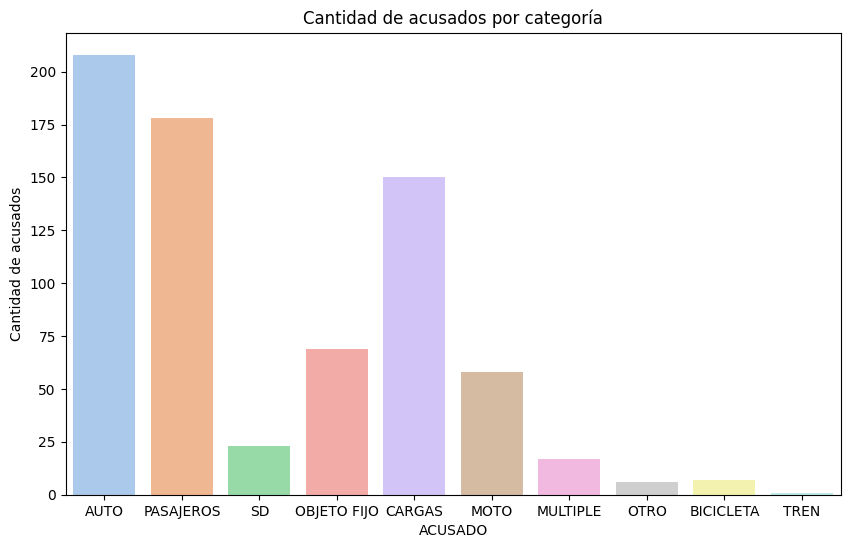

In [263]:
# Gráfico de cantidad de acusados por categoría
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data=df_victimas, x='ACUSADO', palette='pastel')
ax.set_title('Cantidad de acusados por categoría')
ax.set_ylabel('Cantidad de acusados')
plt.show()

In [69]:
contingencia = pd.crosstab(hechos["VICTIMA"], hechos["ACUSADO"])

In [70]:
contingencia

ACUSADO,AUTO,BICICLETA,CARGAS,MOTO,MULTIPLE,OBJETO FIJO,OTRO,PASAJEROS,SD,TREN
VICTIMA,,,,,,,,,,
AUTO,31,0,14,0,3,22,1,9,4,0
BICICLETA,8,0,10,0,1,0,1,8,0,1
CARGAS,1,0,4,0,0,1,0,1,0,0
MOTO,83,2,78,25,8,40,4,46,9,0
MOVIL,0,0,1,0,0,0,0,1,0,0
PASAJEROS,1,0,0,0,0,0,0,3,1,0
PEATON,77,5,38,30,5,0,0,105,4,0
PEATON_MOTO,0,0,0,1,0,0,0,0,0,0
SD,2,0,1,1,0,0,0,0,5,0


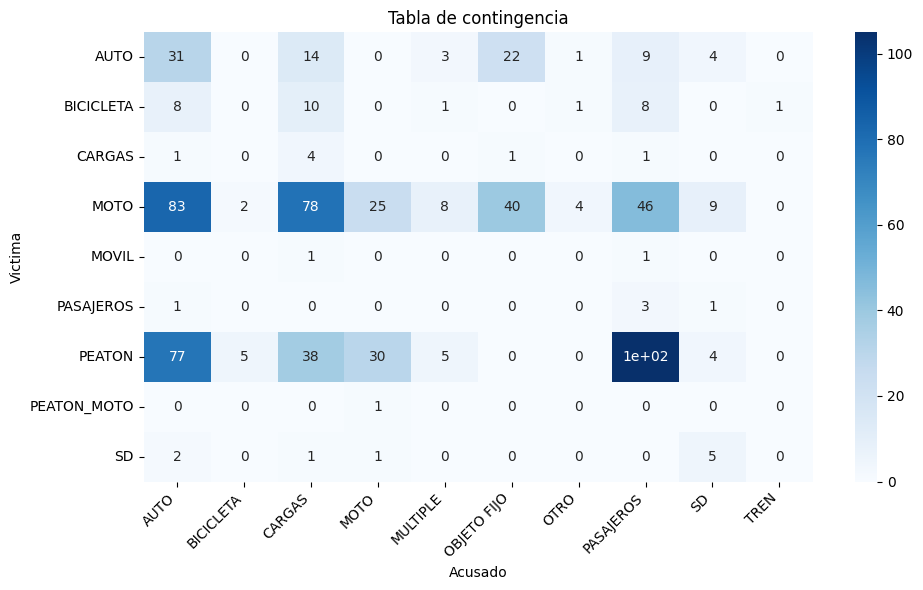

In [71]:
plt.figure(figsize=(10, 6))
sns.heatmap(contingencia, annot=True, cmap='Blues')  


plt.xlabel('Acusado')
plt.ylabel('Victima')
plt.title('Tabla de contingencia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

#### PRINCIPALES VICTIMAS Y SUS ACUSADOS

- **PEATONES** víctimas por impacto contra **COLECTIVOS**: 105<br>
- **PEATONES** víctimas por impacto contra **AUTOS: 77**

- **MOTOS** víctimas por colisión con **AUTOS**: 83<br>
- **MOTOS** víctimas por colisión con **CAMIONES**: 78



### ROL DE LA VICTIMA

In [73]:
victimas["ROL"].value_counts()

ROL
CONDUCTOR               330
PEATON                  267
PASAJERO_ACOMPAÑANTE     80
CICLISTA                 29
SD                       11
Name: count, dtype: int64

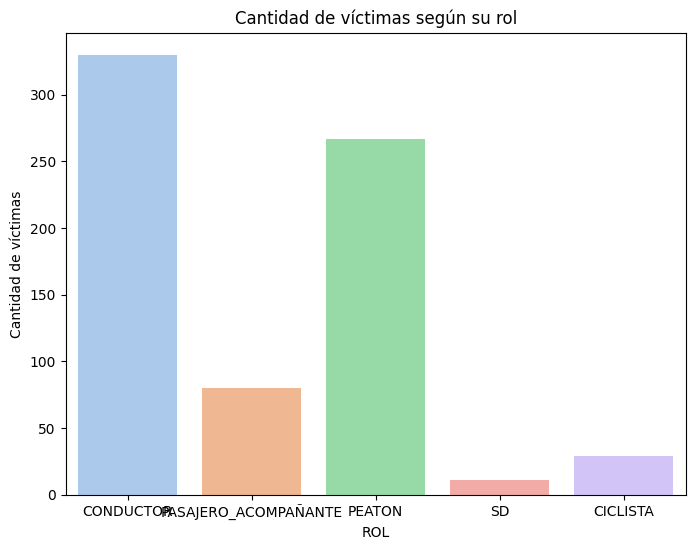

In [264]:
# Gráfico de cantidad de víctimas según su rol
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df_victimas, x='ROL', palette='pastel')
ax.set_title('Cantidad de víctimas según su rol')
ax.set_ylabel('Cantidad de víctimas')
plt.show()

In [74]:
contingencia2 = pd.crosstab(victimas["VICTIMA"], victimas["ROL"])
contingencia2

ROL,CICLISTA,CONDUCTOR,PASAJERO_ACOMPAÑANTE,PEATON,SD
VICTIMA,,,,,
AUTO,0,65,29,0,0
BICICLETA,29,0,0,0,0
CARGAS,0,3,4,0,0
MOTO,0,261,39,0,3
MOVIL,0,1,2,0,0
PASAJEROS,0,0,5,0,0
PEATON,0,0,0,267,0
SD,0,0,1,0,8


VEHICULO Y ROL DE LAS VICTIMAS:
* 37% Peatones - 267
* 36% Conductor de moto - 261
* 10% Conductor de auto - 65
* 6% Acompañante de en moto - 39
* 4% Acompañante en auto - 29
* otros

#### **El 75% de las víctimas son peatones y conductores de moto.**

<br><br><br>

### ANALISIS DE LA VARIABLE EDAD DE LAS VICTIMAS

In [97]:
edad = victimas[victimas['EDAD'] != "SD"]

In [100]:
edad["EDAD"] = edad['EDAD'].astype(int)

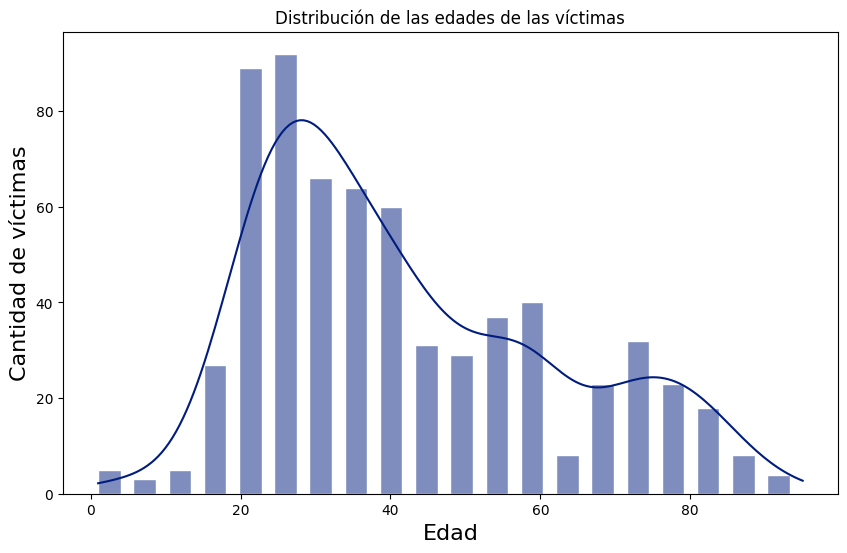

In [106]:
plt.figure(figsize=(10, 6))

# Histograma con 20 bins
sns.histplot(edad['EDAD'], bins=20, kde=True)

# Configuración de los ejes y título
plt.xlabel('Edad', fontsize=16)  # Ajustar el tamaño de la fuente en el eje x
plt.ylabel('Cantidad de víctimas', fontsize=16)  # Ajustar el tamaño de la fuente en el eje y
plt.title('Distribución de las edades de las víctimas')

# Ajustar el ancho de las columnas y los colores
bars = plt.gca().patches
for bar in bars:
    bar.set_width(3)  # Ajustar el ancho de las columnas
    bar.set_edgecolor('white')  # Ajustar el color del borde de las columnas

# Mostrar el gráfico
plt.show()

In [185]:
# Calcular la media
media_edad = np.mean(edad['EDAD'])
print(f"Media de las edades: {round(media_edad)}")

# Calcular la mediana
mediana_edad = np.median(edad['EDAD'])
print(f"Mediana de las edades: {round(mediana_edad)}")

# Calcular la moda
moda_edad = stats.mode(edad['EDAD'])
print(f"Moda de las edades: {moda_edad[0]} (con frecuencia: {moda_edad[1]})")

# Calcular la desviación estándar de la edad
desviacion_estandar_edad = edad['EDAD'].std()
print("Desviación Estándar de la Edad:", round(desviacion_estandar_edad,1))

Media de las edades: 42
Mediana de las edades: 37
Moda de las edades: 30 (con frecuencia: 28)
Desviación Estándar de la Edad: 19.8


In [137]:
print(f"RANGO DE EDAD: {edad['EDAD'].min()} año a {edad['EDAD'].max()} años")

RANGO DE EDAD: 1 año a 95 años


In [189]:
# Calcular la asimetría y la kurtosis
asimetria_edad = edad['EDAD'].skew()
print("Asimetría de la Edad:", round(asimetria_edad,3))


Asimetría de la Edad: 0.664


Asimetría de 0.664:
* La distribución de la edad está sesgada a la derecha.
* Hay una mayor concentración de edades más jóvenes, pero algunos valores de edad más altos estiran la distribución hacia la derecha.

<br><br>
BUSCAR OUTLIERS EN LA VARIABLE EDAD

Valores atípicos en la columna EDAD:
Empty DataFrame
Columns: [ID_VICTIMA, ID_HECHO, FECHA, ROL, VICTIMA, SEXO, EDAD, RANGO_ETAREO, FECHA_FALLECIMIENTO]
Index: []


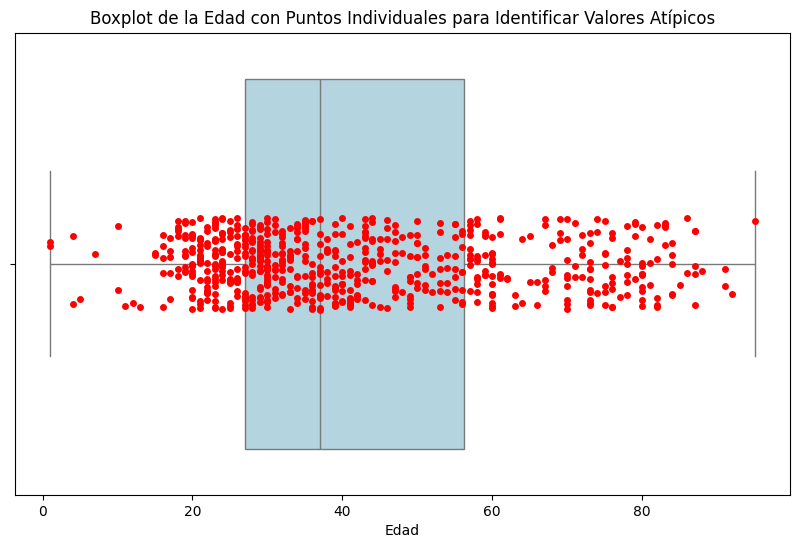

In [140]:
# Calcular el IQR (rango intercuartílico)
Q1 = edad['EDAD'].quantile(0.25)
Q3 = edad['EDAD'].quantile(0.75)
IQR = Q3 - Q1

# Calcular los límites para detectar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificar los valores atípicos
valores_atipicos = edad[(edad['EDAD'] < limite_inferior) | (edad['EDAD'] > limite_superior)]

print(f"Valores atípicos en la columna EDAD:\n{valores_atipicos}")

# Visualizar los valores atípicos con un boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=edad['EDAD'], color='lightblue')

# Superponer los puntos individuales (gráfico de dispersión) para visualizar los outliers
sns.stripplot(x=edad['EDAD'], color='red', jitter=True, size=5)

# Configuración de los ejes y título
plt.xlabel('Edad')
plt.title('Boxplot de la Edad con Puntos Individuales para Identificar Valores Atípicos')

# Mostrar el gráfico
plt.show()

Para evitar los sesgos de los valores estadísticos (como la media y mediana), es preferible evaluar la edad por rango etáreo. Para el cual se utilizó la siguientes categorías:
* Menores de 18
* Entre 18 y 33
* Entre 34 y 49
* Entre 50 y 65
* Mayores de 65

In [160]:
victimas["RANGO_ETAREO"].value_counts()

RANGO_ETAREO
18_33    264
34_49    167
>65      112
50_65     98
SD        53
<18       23
Name: count, dtype: int64

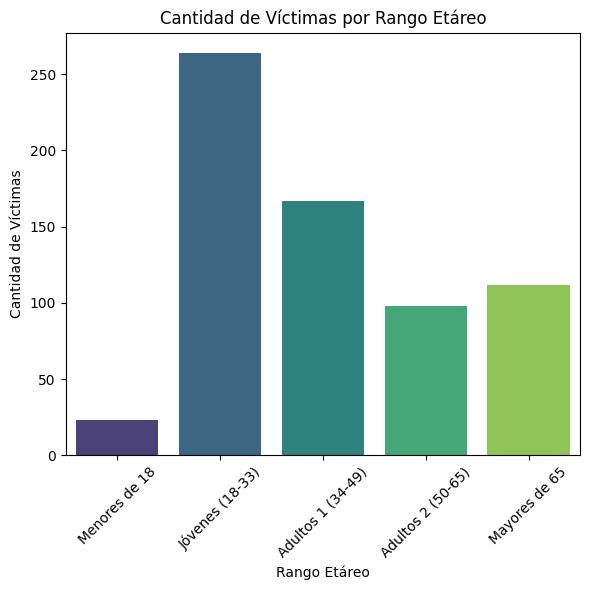

In [180]:
# Definir las nuevas etiquetas
nuevas_etiquetas = {
    '<18': 'Menores de 18',
    '18_33': 'Jóvenes (18-33)',
    '34_49': 'Adultos 1 (34-49)',
    '50_65': 'Adultos 2 (50-65)',
    '>65': 'Mayores de 65'
}

# Crear el gráfico de barras
plt.figure(figsize=(6, 6))
ax = sns.countplot(x='RANGO_ETAREO', data=edad, palette='viridis', order=nuevas_etiquetas.keys())

# Configurar las etiquetas del eje X
ax.set_xticklabels([nuevas_etiquetas.get(label, label) for label in nuevas_etiquetas.keys()], rotation=45)

# Configuración de los ejes y título
plt.xlabel('Rango Etáreo')
plt.ylabel('Cantidad de Víctimas')
plt.title('Cantidad de Víctimas por Rango Etáreo')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Ahora se puede apreciar mejor que la edad entre 18 y 33 años acumula la mayor cantidad de víctimas fatales por accidentes de tránsito, le siguen adultos de entre 34 y 49 años de edad.

<br><br><br>
ANALISIS POR AÑO Y COMUNAS

Víctimas por AÑO y por COMUNA, resaltando la evolución por año de las 3 comunas con mayor cantidad de víctimas totales, y la evolución por año de las 3 comunas con menor cantidad de víctimas totales

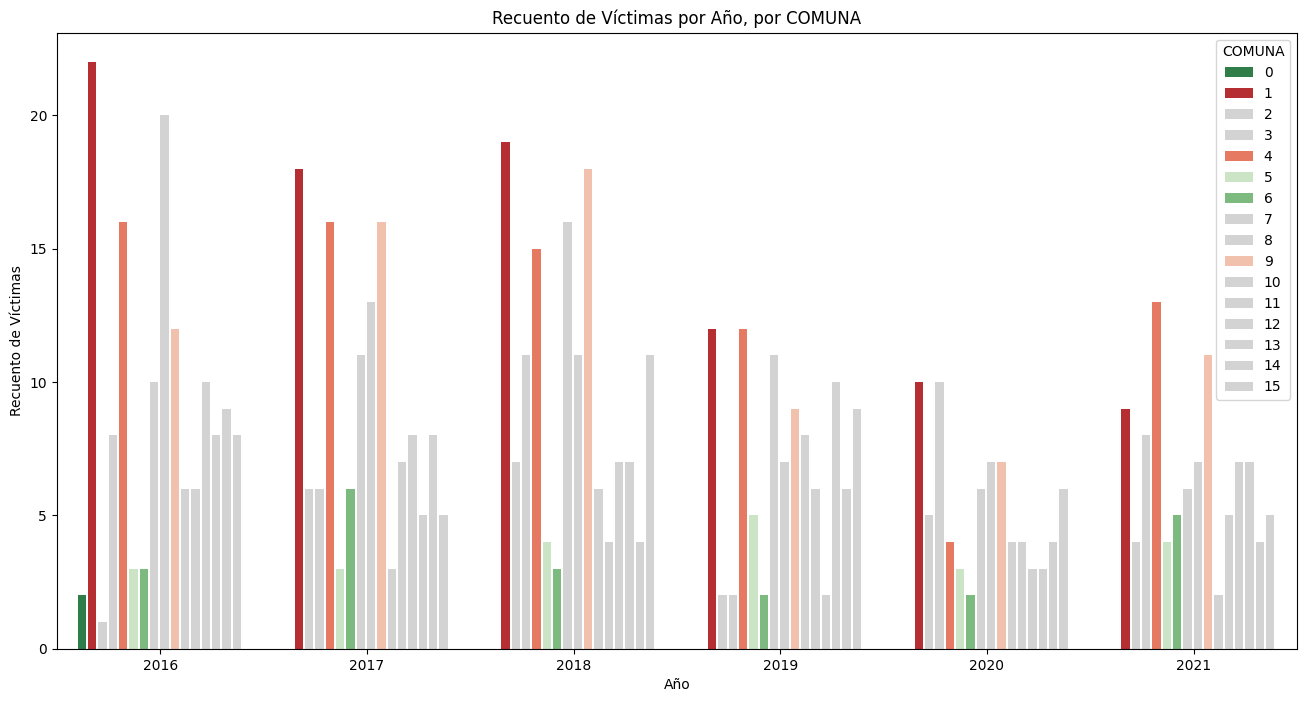

In [211]:
# Calcular las víctimas totales por COMUNA
hechos['Total Víctimas'] = hechos.groupby('COMUNA')['N_VICTIMAS'].transform('sum')

# Identificar las comunas con mayor y menor cantidad de víctimas totales
comunas_con_mas_hechos = hechos.groupby('COMUNA')['Total Víctimas'].sum().nlargest(3)
comunas_con_menos_hechos = hechos.groupby('COMUNA')['Total Víctimas'].sum().nsmallest(3)

# Crear una escala de colores para las comunas con más y menos víctimas
colores_mas_hechos = sns.color_palette("Reds_r", 3)  # De más claro a más oscuro
colores_menos_hechos = sns.color_palette("Greens", 3)  # De más oscuro a más claro

# Asignar colores a las comunas
palette_dict = {}
for comuna in hechos['COMUNA'].unique():
    if comuna in comunas_con_mas_hechos.index:
        # Asignar el color según el orden de las víctimas
        idx = comunas_con_mas_hechos.index.get_loc(comuna)
        palette_dict[comuna] = colores_mas_hechos[idx]
    elif comuna in comunas_con_menos_hechos.index:
        # Asignar el color según el orden inverso de las víctimas
        idx = comunas_con_menos_hechos.index.get_loc(comuna)
        palette_dict[comuna] = colores_menos_hechos[::-1][idx]
    else:
        palette_dict[comuna] = 'lightgrey'

# Crear el gráfico
plt.figure(figsize=(16, 8))
ax = sns.countplot(data=hechos, x='ANIO', hue='COMUNA', palette=palette_dict)

# Personalizar el gráfico
plt.xlabel('Año')
plt.ylabel('Recuento de Víctimas')
plt.title('Recuento de Víctimas por Año, por COMUNA')

# Ajustar el ancho de las columnas
for patch in ax.patches:
    patch.set_width(0.04)

# Mostrar el gráfico
plt.show()

Se puede observar que a lo largo de los años, las comunas 1 (Retiro, San Nicolás, Puerto Madero, San Telmo, Montserrat y Constitución), 4 (La Boca, Barracas, Parque Patricios y Nueva Pompeya) y 9 (Liniers, Mataderos y Parque Avellaneda), son las comunas con la mayor cantidad de víctimas, y las comunas 5 (Almagro y Boedo), 2 (Recoleta) y 6 (Caballito), son las comunas con un menor número de víctimas en accidentes de transito.

<br>
<br>

Gráfico de mapa de calor para los totales de incidentes por día de la semana y franja horaria

In [232]:
hechos["DIA_SEMANA"].value_counts()

DIA_SEMANA
LUNES        106
SABADO       102
DOMINGO      100
MARTES        99
MIERCOLES     98
VIERNES       97
JUEVES        94
Name: count, dtype: int64

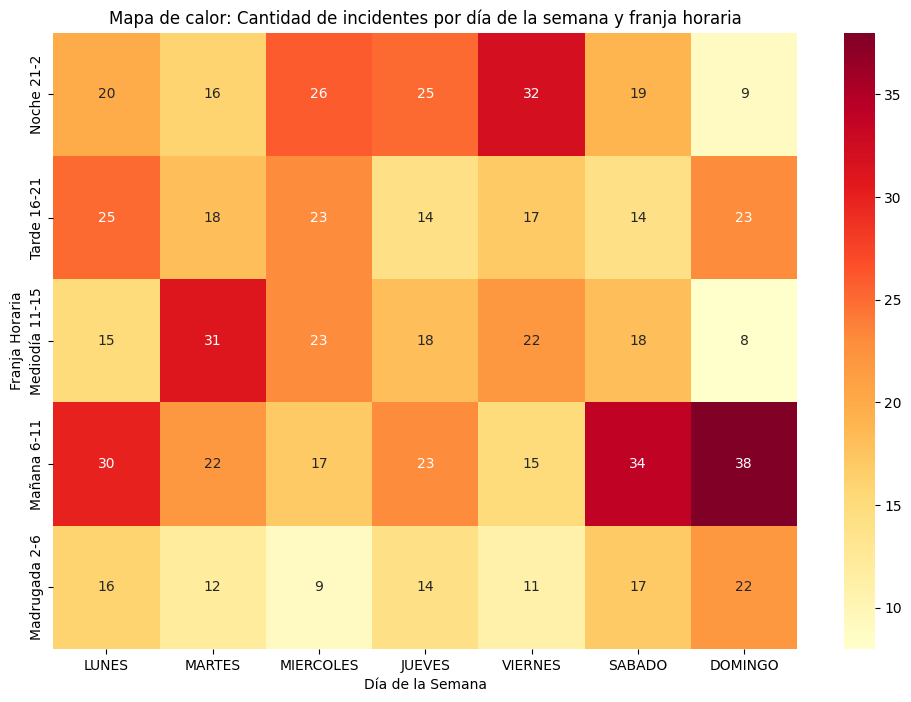

In [235]:
# Establecer el orden de los días de la semana
dias_ordenados = ['LUNES', 'MARTES', 'MIERCOLES', 'JUEVES', 'VIERNES', 'SABADO', 'DOMINGO']
hechos['DIA_SEMANA'] = pd.Categorical(hechos['DIA_SEMANA'], categories=dias_ordenados, ordered=True)

# Crear una tabla dinámica (pivot table) para el mapa de calor
pivot_table = hechos.pivot_table(index='FRANJA_HORARIA', columns='DIA_SEMANA', aggfunc='size', fill_value=0)

# Revertir el orden de las franjas horarias
pivot_table = pivot_table.reindex(index=pivot_table.index[::-1])

# Crear el gráfico de mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='d', cbar=True)
plt.xlabel('Día de la Semana')
plt.ylabel('Franja Horaria')
plt.title('Mapa de calor: Cantidad de incidentes por día de la semana y franja horaria')

# Configurar las etiquetas de los ticks en el eje y
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=['Noche 21-2', 'Tarde 16-21', 'Mediodía 11-15', 'Mañana 6-11', 'Madrugada 2-6'])
plt.show()

Se observa que los fines de semana los siniestros se concentran fuertemente en la mañana (probablemente más cerca de las 6, horario en que vuelven especialmente jóvenes de lugares de esparcimiento donde suele haber ingesta de alcohol). Y los días de semana se observa que los siniestros ocurren en otros horarios (despues de las 21, también en el horario de salida laboral en la tarde y al medio día en algunos casos, y los lunes en la mañana cuando reinician las actividades).